In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
from sklearn.covariance import GraphicalLasso
import sklearn
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
df=pd.read_pickle("./cleanData_model.pkl")

# Preparing HVI Data

In [ ]:
#INITIALIZE VARIABLES BASED ON NUMERICAL OR CATEGORICAL
target='SALEPRICE'
numerical=[
            # 'lng-zip',
            # 'lat-zip',
            # 'LOTAREA',
            'saledate-int',
            # 'prevsaledate-int',
            # 'prevsaledate2-int',
            # 'PREVSALEPRICE',
            # 'PREVSALEPRICE2',
            'FINISHEDLIVINGAREA',
            # 'STORIES',
            'YEARBLT',
            'CARDNUMBER',
            'BSMTGARAGE',
            'FIREPLACES',
            'HALFBATHS',
            'FULLBATHS',
            'TOTALROOMS'
            ]
categorical=[
            # 'SCHOOLCODE',
            # 'TAXCODE',
            # 'TAXSUBCODE',
            'OWNERCODE',
            'CLASS',
            'ROOF',
            'BASEMENT',
            # 'LOCALLAND',
            'FAIRMARKETBUILDING',
            'FAIRMARKETLAND',
            'STYLE',
            'ROOF',
            'BASEMENT',
            'GRADE',
            'CONDITION',
            # 'HEATINGCOOLING',
            'PARID',
            'MUNICODE',
            'USECODE',
            # 'HOMESTEADFLAG',
            # 'FARMSTEADFLAG',
            'CLEANGREEN',
            # 'ABATEMENTFLAG',
            'SALECODE',
            'COUNTYBUILDING',
            'COUNTYLAND',
            'EXTERIORFINISH',
            # 'CDU'
            ]

In [ ]:
df_sample=df

X=df_sample[numerical+categorical]
y=df_sample[target]


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


# Training Model

In [ ]:
import xgboost as xg 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score 


# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 110, seed = 10) 
  
# Fitting the model 
xgb_r.fit(X_scaled, y);
# pickle.dump(xgb_r, open('models/XGB2.pkl', 'wb'))

In [ ]:
xgb_r.score(X_scaled, y)

0.8673892929246007

# Creating HVI Analysis

In [ ]:
#GROUPING  ALL PARCEL IDS TOGETHER AND GETTING THEIR MEAN
X_props=X.groupby('PARID').mean()
X_props['PARID']=X_props.index

In [ ]:
#FIGURING OUT HOW TO SPACE OUT THE DATES TO QUERY ONCE PER MONTH

print('First date:',min(df['SALEDATE']))
print('Last date:',max(df['SALEDATE']))

numberOfMonths=int((max(df['SALEDATE'])-min(df['SALEDATE']))/ np.timedelta64(1, 'M'))
print('Number of months:',numberOfMonths)

#CREATING A SET OF MONTLY DATES TO QUERY THE MODEL IN
XDates=np.linspace(min(df['SALEDATE']).value,max(df['SALEDATE']).value,numberOfMonths)
XDates=pd.to_datetime(XDates)
XDatesInt=mdates.date2num(XDates)

First date: 1870-11-12 00:00:00
Last date: 2021-01-25 00:00:00
Number of months: 1802


In [ ]:
xgb_r = pickle.load(open('models/XGB2.pkl', 'rb'))

In [ ]:
#FUNCTION TO COMPUTE APPRECIATION FOR EXISITNG HOMES IN A YEAR
def computeAppreciation(y_new,y_old,y_consider):
    '''
    Description:
        Compoutes appretiation for all existing properties for a given time period.   
    Input: 
        y_new - (list) containing new predicted property values
        y_old - (list) cotaining old predicted property values
        y_consider (list) containing index of properties to consider based on year built
    Output:
        (float) appreciation for a given time period 
    '''
    assert isinstance(y_new, list), 'Wrong type for first input -- should be list'   
    assert isinstance(y_old, list), 'Wrong type for second input -- should be list'   
    assert isinstance(y_consider, list), 'Wrong type for third input -- should be list'   

    y_old_sum=np.sum(y_old)
    appr=0
    for j in y_consider:
        #COMPUTE APROPERTY APPRECIATION
        a=(y_new[j]-y_old[j])/y_old[j]
        #COMPUTE PROPERTY WEIGHT
        w_old=y_new[j]/y_old_sum

        #ADD WEIGHTED APPRECIATION TO SUM OF APPRECIATION FOR ALL PROPERTIES
        appr+=a*w_old
    return appr

#GROUP DATAPOINTS BASED ON PARCEL ID
X_props=X.groupby('PARID').mean() #group by properties
X_props['PARID']=X_props.index #add index back into dataset

appretiation={}
y_old=[]
#ITERATE OVER THE DEFINED DATES
for i in range(0,len(XDates),1):
    #REPLACE
    X_props['saledate-int']=XDatesInt[i]*5 #update the saledate for existing properties
    X_props_scaled = scaler.transform(X_props) #standardize values based on previous information
    y_new=xgb_r.predict(X_props_scaled)
    y_consider=np.where(X_props['YEARBLT'].le(XDates[i].year))[0]

    #TRY TO CREATE NORMAL VALUES AND IF FAIL IT MOST BE FIRST TIME (ENSURES COMPUTATIONAL EFFICIENCY OVER IF STATEMENT)
    try:
        #COMPUTE APPRECIATION FOR DATE
        apr=appretiation[XDates[i]]=computeAppreciation(y_new,y_old,y_consider)
    except:
        #INITIALIZE OLD WITH ZEROS
        y_old=np.zeros(len(y_new))
        #ADD THE MEAN OF ALL VALUES AS THE MEAN OF ALL CONSIDERED HOUSES
        y_old[y_consider]=np.mean(y_new[y_consider])
        apr=appretiation[XDates[i]]=computeAppreciation(y_new,y_old,y_consider)
    #MAKE THE NEW PREDICTIONS BECOME THE OLD PREDICTIONS FOR NEXT ITERATION
    y_old=y_new
    #SAVE INFORMATION TO DICTIONARY
    appretiation[XDates[i]]={'apr':apr,'y_new_mean':np.mean(y_new)}
    # print(XDates[i],':',apr)

# pickle.dump(appretiation, open('models/appr3.pkl', 'wb'))

In [2]:
appr = pickle.load(open('models/appr3.pkl', 'rb'));

#EXTRACT THE INFORMATION FROM DICTIONARY FOR FURHTER ANALYSIS
a=[]
dat=[]
mean=[]

for k in appr:
    a.append(appr[k]['apr'])
    mean.append(appr[k]['y_new_mean'])
    dat.append(k)


In [5]:
#COMPUTE THE HOUSE VALUE INDEX
#THE FIRST VALUE IS THE MEAN OF THE HOUSE VALUES
I=[df[pd.to_datetime('2021')<=df['SALEDATE']]['SALEPRICE'].mean()]
ct=1
#ITERATE BACKWARDS TO COMPUTE THE PRIVOUS DATE USING CURRENT DATE
for k in np.arange(len(a)-2,-1,-1):
    I.append(I[ct-1]/(1+a[k]))
    ct+=1

Text(0, 0.5, 'Home Value Index in USD')

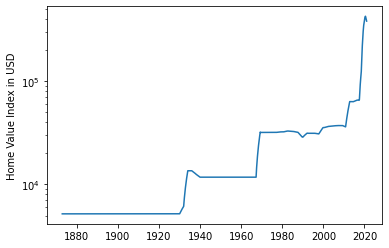

In [7]:
def movingAvg(dat_in,mask_size):
    '''
    Description:
        Computes the moving average using previous values. First mask_size values are set to 0
    Input: 
        data_in - (list) list containing the data to be averaged
        mask_size - (int) number of values before current value to use for average
    Output:
        (float) appreciation for a given time period 
    '''
    assert isinstance(dat_in, list), 'Wrong type for first input -- should be list'   
    assert isinstance(mask_size, int), 'Wrong type for second input -- should be an int'
    avgData=np.zeros(len(dat_in))
    for i in range(mask_size,len(dat_in)):
        mean=0
        for j in range(mask_size):
            mean+=dat_in[i-j]
        mean=mean/mask_size
        avgData[i]=mean
    return avgData

#CREATE WINDOW SIZE OF TWO YEARS AND COMPUTE MOVING AVERAGE
window=12*2
moving_averages = movingAvg(I[::-1],window)

#PLOT SEMILOT OF THE MOVING AVERAGE
plt.semilogy(dat[window:],moving_averages[window:],'-')
plt.ylabel('Home Value Index in USD')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4d883e40-705b-4ee7-9326-895000a955f5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>